# MLP

In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F

# set print options to avoid scientific notation
torch.set_printoptions(sci_mode=False, precision=2)

In [2]:
from datasets import load_dataset
import numpy as np

# load the MNIST dataset
ds = load_dataset("ylecun/mnist")
ds

# convert PIL image to normalized PyToch tensor
def image_to_tensor(image):
    return torch.tensor(np.array(image)) / 255.0


def preprocess_data(split):
    
    x = []  # list to store image tensors
    y = []  # list to store labels

    for example in split:
        x.append(image_to_tensor(example['image']))
        y.append(example['label'])
    
    return torch.stack(x), torch.tensor(y)

train_x, train_y = preprocess_data(ds['train'])

In [3]:
print(train_x.shape)
print(train_y.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])


In [4]:
train_x[0]

tensor([[0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00,
         0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00,
         0.00, 0.00, 0.00, 0.00],
        [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00,
         0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00,
         0.00, 0.00, 0.00, 0.00],
        [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00,
         0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00,
         0.00, 0.00, 0.00, 0.00],
        [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00,
         0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00,
         0.00, 0.00, 0.00, 0.00],
        [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00,
         0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00,
         0.00, 0.00, 0.00, 0.00],
        [0.00, 0.00,

In [5]:
train_y[0]

tensor(5)

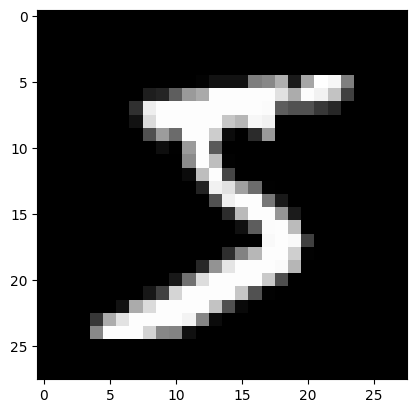

In [6]:
plt.imshow(train_x[0], cmap='gray');

## MLP

In [7]:
def initialize_nn(n_hidden = 100):

    g = torch.Generator().manual_seed(1)
    
    W1 = torch.randn((784, n_hidden),      generator=g)
    b1 = torch.zeros(n_hidden)
    W2 = torch.randn((n_hidden, n_hidden), generator=g)
    b2 = torch.zeros(n_hidden)
    W3 = torch.randn((n_hidden, 10),       generator=g)
    b3 = torch.zeros(10)

    parameters = [W1, b1, W2, b2, W3, b3]

    for p in parameters:
        p.requires_grad = True

    return parameters

train_x.view(-1, 784)

In [8]:
steps = 100        # train iterations
lr = 0.1           # learning rate
loss_graph = []

# intialize neural network
parameters = initialize_nn()
W1, b1, W2, b2, W3, b3 = parameters

for step in range(steps):
    
    # forward pass
    h1 = torch.tanh(train_x.view(-1, 784) @ W1 + b1)  # (examples, n_hidden) = (examples, 784) x (784, n_hidden) + (n_hidden)
    h2 = torch.tanh(h1 @ W2 + b2)                     # (examples, n_hidden) = (examples, n_hidden) x (n_hidden, n_hidden) + (n_hidden)
    o = h2 @ W3 + b3                                  # (examples, 10) = (examples, n_hidden) x (n_hidden, 10) + (10)
    
    # calculate loss
    loss = F.cross_entropy(o, train_y)
    loss_graph.append(loss.item())
    if step % 10 == 0 or step == steps - 1:
        print(f"Step: {step:2d}/{steps}     Loss: {loss.item():.4f}")
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update parameters
    for p in parameters:
        p.data += -lr * p.grad

Step:  0/100     Loss: 15.9699
Step: 10/100     Loss: 10.9262
Step: 20/100     Loss: 8.3451
Step: 30/100     Loss: 6.7141
Step: 40/100     Loss: 5.6266
Step: 50/100     Loss: 4.8790
Step: 60/100     Loss: 4.3457
Step: 70/100     Loss: 3.9500
Step: 80/100     Loss: 3.6406
Step: 90/100     Loss: 3.3900
Step: 99/100     Loss: 3.2024


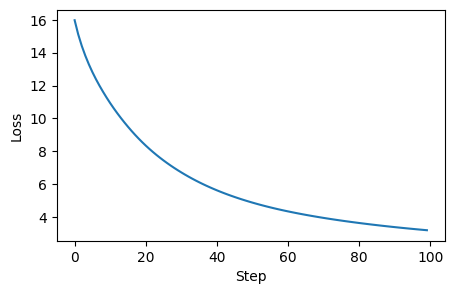

In [9]:
plt.figure(figsize=(5, 3))
plt.plot(loss_graph)
plt.xlabel('Step')
plt.ylabel('Loss');

## Batches

As observed, the neural network was slowly reducing the loss, and therfore learning. However,each training step took a considerable amount of time to complete because it is quite computatuonally expensive to process the entire dataset of 60,000 examples for both forward and backward passes.

To address this issue, we will use **mini-batches** (small randomly selected subsets of the dataset) rather than the entire training set in each iteration. This approach reduces computation time while still maintaining the benefits of gradient descent.

```{admonition} Help
:class: dropdown
`torch.randint(0, X.shape[0], (32,))` randomly generates 32 integers between 0 and Xtr.shape[0] that index into our dataset.
```

In [10]:
steps = 100        # train iterations
lr = 0.1           # learning rate
batch_size = 32

loss_graph = []
g = torch.Generator().manual_seed(1)

# intialize neural network
parameters = initialize_nn()
W1, b1, W2, b2, W3, b3 = parameters

for step in range(steps):
    
    # batch construction
    ix = torch.randint(0, train_x.shape[0], (batch_size,), generator=g)
    Xb = train_x[ix].view(-1, 784)
    Yb = train_y[ix]
    
    # forward pass
    h1 = torch.tanh(Xb @ W1 + b1)  # (batch_size, n_hidden) = (batch_size, 784) x (784, n_hidden) + (n_hidden)
    h2 = torch.tanh(h1 @ W2 + b2)  # (batch_size, n_hidden) = (batch_size, n_hidden) x (n_hidden, n_hidden) + (n_hidden)
    o = h2 @ W3 + b3               # (batch_size, 10) = (batch_size, n_hidden) x (n_hidden, 10) + (10)
    
    # calculate loss
    loss = F.cross_entropy(o, Yb)
    loss_graph.append(loss.item())
    if step % 10 == 0 or step == steps - 1:
        print(f"Step: {step:2d}/{steps}     Loss: {loss.item():.4f}")
        
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update parameters
    for p in parameters:
        p.data += -lr * p.grad

Step:  0/100     Loss: 19.2715
Step: 10/100     Loss: 9.7469
Step: 20/100     Loss: 9.2240
Step: 30/100     Loss: 7.1574
Step: 40/100     Loss: 5.5388
Step: 50/100     Loss: 3.6040
Step: 60/100     Loss: 3.6486
Step: 70/100     Loss: 5.2210
Step: 80/100     Loss: 3.3407
Step: 90/100     Loss: 2.6224
Step: 99/100     Loss: 3.0554


The loss we see is the loss of each batch. The loss of the whole dataset is:

In [11]:
def train_loss():

    # forward pass
    h1 = torch.tanh(train_x.view(-1, 784) @ W1 + b1)  # (examples, n_hidden) = (examples, 784) x (784, n_hidden) + (n_hidden)
    h2 = torch.tanh(h1 @ W2 + b2)                     # (examples, n_hidden) = (examples, n_hidden) x (n_hidden, n_hidden) + (n_hidden)
    o = h2 @ W3 + b3                                  # (examples, 10) = (examples, n_hidden) x (n_hidden, 10) + (10)

    # calculate loss
    loss = F.cross_entropy(o, train_y)
    
    return loss.item()

In [12]:
print(f"Train Loss: {train_loss():.4f}")

Train Loss: 3.3288


This way we can run **many examples** nearly instantly and decrease the loss **much faster**. Because we are only dealing with mini-batches the quality of our gradient is lower (it is not the actual gradient direction) but the gradient direction is good enough even when it is estimating on only 32 examples. Thus, it is better to evaluate an approximate gradient, and just make more faster steps, than evaluate the exact gradient, and take fewer lower steps.

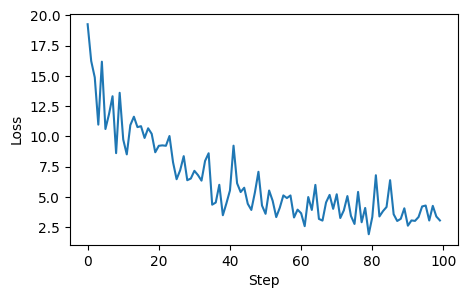

In [13]:
plt.figure(figsize=(5, 3))
plt.plot(loss_graph)
plt.xlabel('Step')
plt.ylabel('Loss');

## Loss function

In [14]:

"""probs = o.exp() / o.exp().sum(1, keepdims=True)      # softmax

# calculate loss
loss = -probs[torch.arange(o.shape[0]), train_y].log().mean()

print(f"Loss: {loss.item():.4f}")"""

'probs = o.exp() / o.exp().sum(1, keepdims=True)      # softmax\n\n# calculate loss\nloss = -probs[torch.arange(o.shape[0]), train_y].log().mean()\n\nprint(f"Loss: {loss.item():.4f}")'

## Intialization

On epoch step 0 we got a loss of 12.97. Then, the loss rapidly decreased to 11. **We should expect a lower loss at initialization**.

At initialization we have no reason to believe that any number is more likely than other. Thus, initially we should expect a uniform probabilty distribution assigning about equal probability (1/10) to all the 10 numbers. Hence, we should expect an **initialization loss** close to:

In [15]:
print(f"Expected Loss: {-torch.tensor(1/10).log():.4f}")

Expected Loss: 2.3026


Run a single forward pass:

In [16]:
g = torch.Generator().manual_seed(1)

# intialize neural network
parameters = initialize_nn()
W1, b1, W2, b2, W3, b3 = parameters

# batch construction
ix = torch.randint(0, train_x.shape[0], (batch_size,), generator=g)
Xb = train_x[ix].view(-1, 784)
Yb = train_y[ix]

# forward pass
h1 = torch.tanh(Xb @ W1 + b1)
h2 = torch.tanh(h1 @ W2 + b2)
o = h2 @ W3 + b3
probs = o.exp() / o.exp().sum(1, keepdims=True)

# calculate loss
loss = -probs[torch.arange(o.shape[0]), Yb].log().mean()
print(f"Initial Loss: {loss:.4f}")

Initial Loss: 19.2715


The issue is that at initialization the **logits coming out of the neural net are not uniform** (they are extreme randomly positive or negative numbers). Some characters are very confident and some characters are very not confident so the network is very confidently wrong recording a high loss.

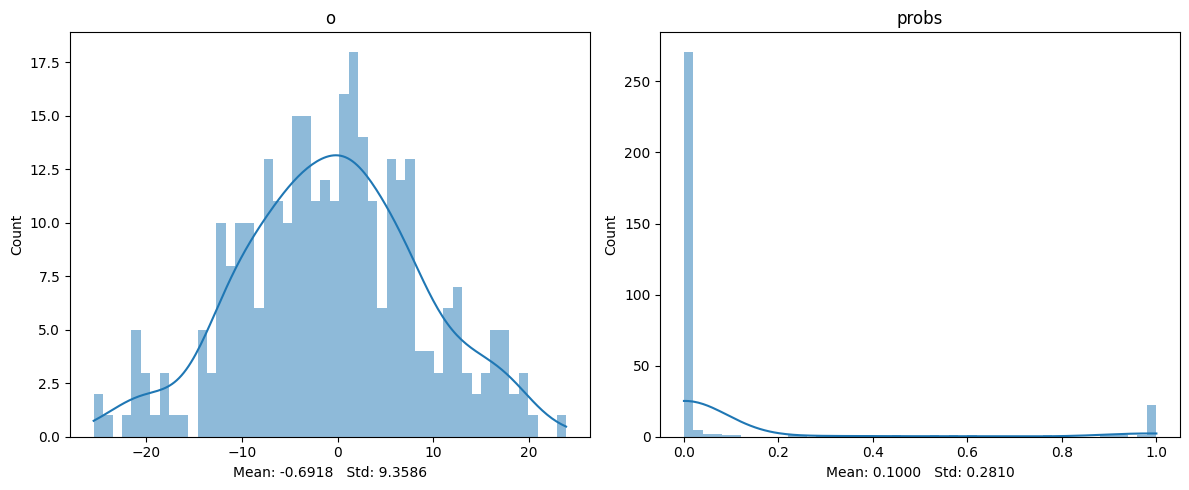

In [17]:
plt.figure(figsize=(12,5))

plt.subplot(121)
sns.histplot(o.view(-1).tolist(), bins=50, kde=True, edgecolor='none');
plt.title('o')
plt.xlabel(f'Mean: {o.mean():.4f}   Std: {o.std():.4f}')

plt.subplot(122)
sns.histplot(probs.view(-1).tolist(), bins=50, kde=True, edgecolor='none');
plt.title('probs')
plt.xlabel(f'Mean: {probs.mean():.4f}   Std: {probs.std():.4f}')

plt.tight_layout()

Fix
We have to make the logits closer to 0 so they are more uniform.

Remember that logits = h @ W2 + b2.

Because we want logits to be closer to 0 at initialization we can multiply b2 by 0.

Because we want logits to be closer to 0 at initialization we can multiply W2 by 0.01.

Note: We multiply W2 by 0.01 instead of 0 so there is some antropy.


In [18]:
def initialize_nn(n_hidden = 100):

    g = torch.Generator().manual_seed(1)
    
    W1 = torch.randn((784, n_hidden),      generator=g)
    b1 = torch.zeros(n_hidden)
    W2 = torch.randn((n_hidden, n_hidden), generator=g)
    b2 = torch.zeros(n_hidden)
    W3 = torch.randn((n_hidden, 10),       generator=g) * 0.1
    b3 = torch.zeros(10)
    
    parameters = [W1, b1, W2, b2, W3, b3]
    
    for p in parameters:
        p.requires_grad = True
    
    return parameters

In [19]:
g = torch.Generator().manual_seed(1)

# intialize neural network
parameters = initialize_nn()
W1, b1, W2, b2, W3, b3 = parameters

# batch construction
ix = torch.randint(0, train_x.shape[0], (batch_size,), generator=g)
Xb = train_x[ix].view(-1, 784)
Yb = train_y[ix]

# forward pass
h1 = torch.tanh(Xb @ W1 + b1)
h2 = torch.tanh(h1 @ W2 + b2)
o = h2 @ W3 + b3
probs = o.exp() / o.exp().sum(1, keepdims=True)

# calculate loss
loss = -probs[torch.arange(o.shape[0]), Yb].log().mean()
print(f"Initial Loss: {loss:.4f}")

Initial Loss: 3.0767


The logits coming out of the nueral net are more uniform so the network is less confidently wrong recording a lower initialization loss closer to what we expected (3.2958).
Train loss and dev loss are lower because we are spending the first several thousand iterations optimizing the neural net instead of just squashing down the weights.

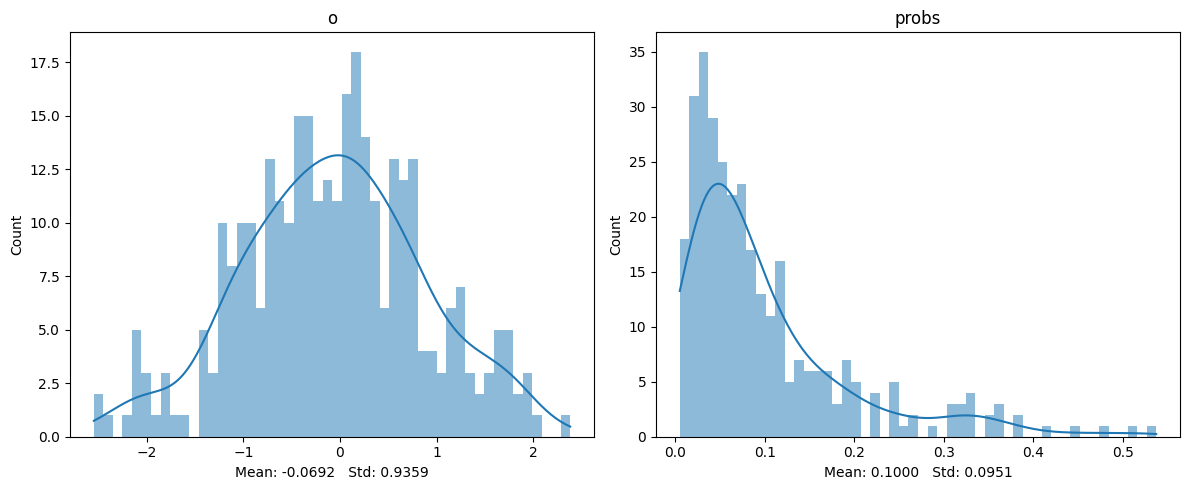

In [20]:
plt.figure(figsize=(12,5))

plt.subplot(121)
sns.histplot(o.view(-1).tolist(), bins=50, kde=True, edgecolor='none');
plt.title('o')
plt.xlabel(f'Mean: {o.mean():.4f}   Std: {o.std():.4f}')

plt.subplot(122)
sns.histplot(probs.view(-1).tolist(), bins=50, kde=True, edgecolor='none');
plt.title('probs')
plt.xlabel(f'Mean: {probs.mean():.4f}   Std: {probs.std():.4f}')

plt.tight_layout()

## Kaiming Initialization

Many of the 1st layer activations are either -1 or 1. This occurs because the pre-activations range between -20 and 20, leading the tanh function to saturate. As shown in the graph below, tanh squashes input values into the range [-1, 1], with large positive or negative inputs pushed closer to 1 or -1, respectively.

```{figure} ../images/tanh.png
---
width: 300px
name: tanh
---
tanh (Hyperbolic Tangent). Source: {cite}`weisstein_tanh`
```

In [21]:
steps = 100        # train iterations
lr = 0.1           # learning rate
batch_size = 32

g = torch.Generator().manual_seed(1)

# intialize neural network
parameters = initialize_nn()
W1, b1, W2, b2, W3, b3 = parameters

for step in range(steps):
    
    # batch construction
    ix = torch.randint(0, train_x.shape[0], (batch_size,), generator=g)
    Xb = train_x[ix].view(-1, 784)
    Yb = train_y[ix]
    
    # forward pass
    h1_pre = Xb @ W1 + b1
    h1 = torch.tanh(h1_pre)
    h2_pre = h1 @ W2 + b2
    h2 = torch.tanh(h2_pre)
    o = h2 @ W3 + b3
    
    # calculate loss
    loss = F.cross_entropy(o, Yb)
    if step % 10 == 0 or step == steps - 1:
        print(f"Step: {step:2d}/{steps}     Loss: {loss.item():.4f}")
        
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update parameters
    for p in parameters:
        p.data += -lr * p.grad
    
print(f"\nTrain Loss: {train_loss():.4f}")

Step:  0/100     Loss: 3.0767
Step: 10/100     Loss: 2.0398
Step: 20/100     Loss: 1.7603
Step: 30/100     Loss: 1.6258
Step: 40/100     Loss: 1.4919
Step: 50/100     Loss: 1.2398
Step: 60/100     Loss: 1.1056
Step: 70/100     Loss: 1.1658
Step: 80/100     Loss: 1.0998
Step: 90/100     Loss: 1.0376
Step: 99/100     Loss: 0.9125

Train Loss: 1.0446


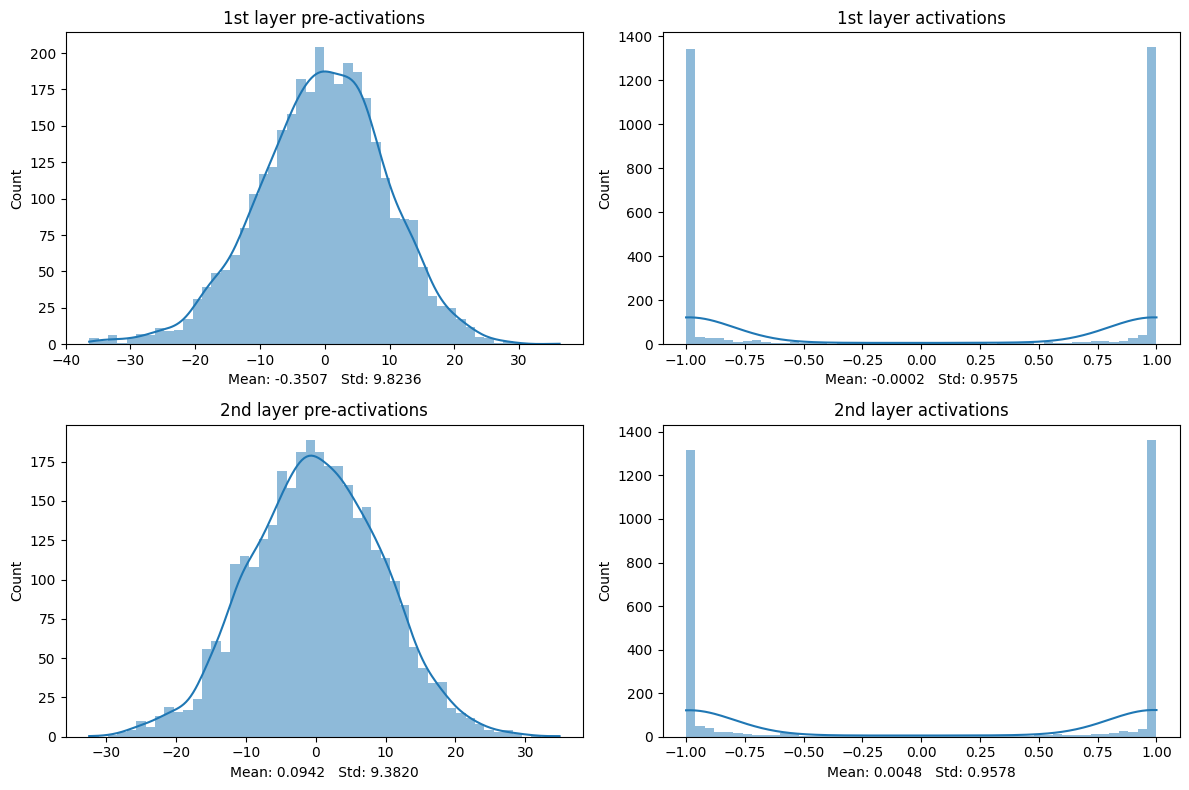

In [22]:
plt.figure(figsize=(12,8))

plt.subplot(221)
sns.histplot(h1_pre.view(-1).tolist(), bins=50, kde=True, edgecolor='none');
plt.title('1st layer pre-activations')
plt.xlabel(f'Mean: {h1_pre.mean():.4f}   Std: {h1_pre.std():.4f}')

plt.subplot(222)
sns.histplot(h1.view(-1).tolist(), bins=50, kde=True, edgecolor='none');
plt.title('1st layer activations')
plt.xlabel(f'Mean: {h1.mean():.4f}   Std: {h1.std():.4f}')

plt.subplot(223)
sns.histplot(h2_pre.view(-1).tolist(), bins=50, kde=True, edgecolor='none');
plt.title('2nd layer pre-activations')
plt.xlabel(f'Mean: {h2_pre.mean():.4f}   Std: {h2_pre.std():.4f}')

plt.subplot(224)
sns.histplot(h2.view(-1).tolist(), bins=50, kde=True, edgecolor='none');
plt.title('2nd layer activations')
plt.xlabel(f'Mean: {h2.mean():.4f}   Std: {h2.std():.4f}')

plt.tight_layout()

If the activations after applying the tanh function are highly saturated (close to 1 or -1), the new gradients become close to zero during backpropagation, which slows down or even halts learning in the neural network:

$$
\text{new gradient} = (1 - \tanh^2(x)) \cdot \text{gradient}
$$

In the figure below, white pixels represent neurons that are highly saturated, effectively destroying the gradient for that example. If an entire row was white, we would have a **dead neuron**. A dead neuron is a neuron that never activates in the non-flat region of tanh and kills all gradients flowing through it, preventing learning.

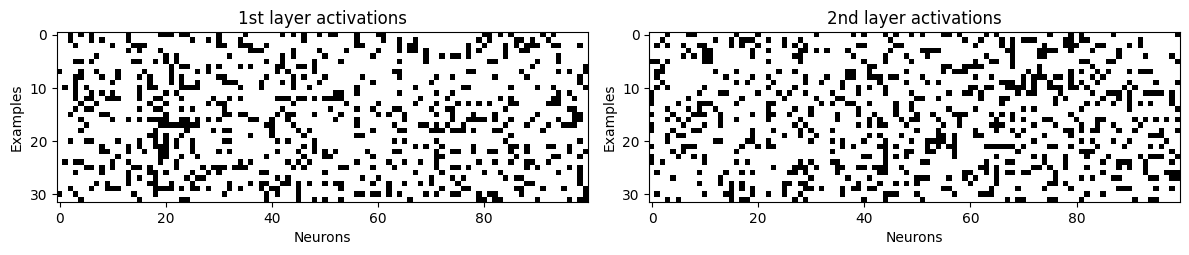

In [23]:
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.imshow(h1.abs() > 0.99, cmap='gray', interpolation='nearest')
plt.title('1st layer activations')
plt.xlabel("Neurons")
plt.ylabel("Examples")

plt.subplot(122)
plt.imshow(h2.abs() > 0.99, cmap='gray', interpolation='nearest')
plt.title('2nd layer activations')
plt.xlabel("Neurons")
plt.ylabel("Examples")

plt.tight_layout()

**Kaiming initialization** (also known as He initialization) is a method used to initialize the weights of a neural network in such a way that the gradients flow more effectively through the network. It was introduced in the paper [He et al. (2015). *Delving Deep into Rectifiers*](https://arxiv.org/pdf/1502.01852) and is particularly important when using nonlinear activation functions such as tanh or ReLU. 


The key idea behind Kaiming initialization is to prevent the activations from becoming too large or too small, which can lead to vanishing or exploding gradients as we just show. It adjusts the weights based on a scaling factor that depends on the activation function (gain) and the number of input units to a neuron (fan-in).

\text{std} = \frac{\text{gain}}{\sqrt{\text{fan-in}}}

In [24]:
def initialize_nn(n_hidden = 100):

    g = torch.Generator().manual_seed(1)
    
    W1 = torch.randn((784, n_hidden),      generator=g) * (5/3) / 784**0.5
    b1 = torch.zeros(n_hidden)
    W2 = torch.randn((n_hidden, n_hidden), generator=g) * (5/3) / n_hidden**0.5
    b2 = torch.zeros(n_hidden)
    W3 = torch.randn((n_hidden, 10),       generator=g) * 0.1
    b3 = torch.zeros(10)
    
    parameters = [W1, b1, W2, b2, W3, b3]
    
    for p in parameters:
        p.requires_grad = True
    
    return parameters

In [25]:
steps = 100        # train iterations
lr = 0.1           # learning rate
batch_size = 32

g = torch.Generator().manual_seed(1)

# intialize neural network
parameters = initialize_nn()
W1, b1, W2, b2, W3, b3 = parameters

for step in range(steps):
    
    # batch construction
    ix = torch.randint(0, train_x.shape[0], (batch_size,), generator=g)
    Xb = train_x[ix].view(-1, 784)
    Yb = train_y[ix]
    
    # forward pass
    h1_pre = Xb @ W1 + b1
    h1 = torch.tanh(h1_pre)
    h2_pre = h1 @ W2 + b2
    h2 = torch.tanh(h2_pre)
    o = h2 @ W3 + b3
    
    # calculate loss
    loss = F.cross_entropy(o, Yb)
    if step % 10 == 0 or step == steps - 1:
        print(f"Step: {step:2d}/{steps}     Loss: {loss.item():.4f}")
        
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update parameters
    for p in parameters:
        p.data += -lr * p.grad
    
print(f"\nTrain Loss: {train_loss():.4f}")

Step:  0/100     Loss: 2.6472
Step: 10/100     Loss: 1.5634
Step: 20/100     Loss: 1.0335
Step: 30/100     Loss: 0.9549
Step: 40/100     Loss: 0.6777
Step: 50/100     Loss: 0.5479
Step: 60/100     Loss: 0.5596
Step: 70/100     Loss: 0.4691
Step: 80/100     Loss: 0.3141
Step: 90/100     Loss: 0.7109
Step: 99/100     Loss: 0.4797

Train Loss: 0.4643


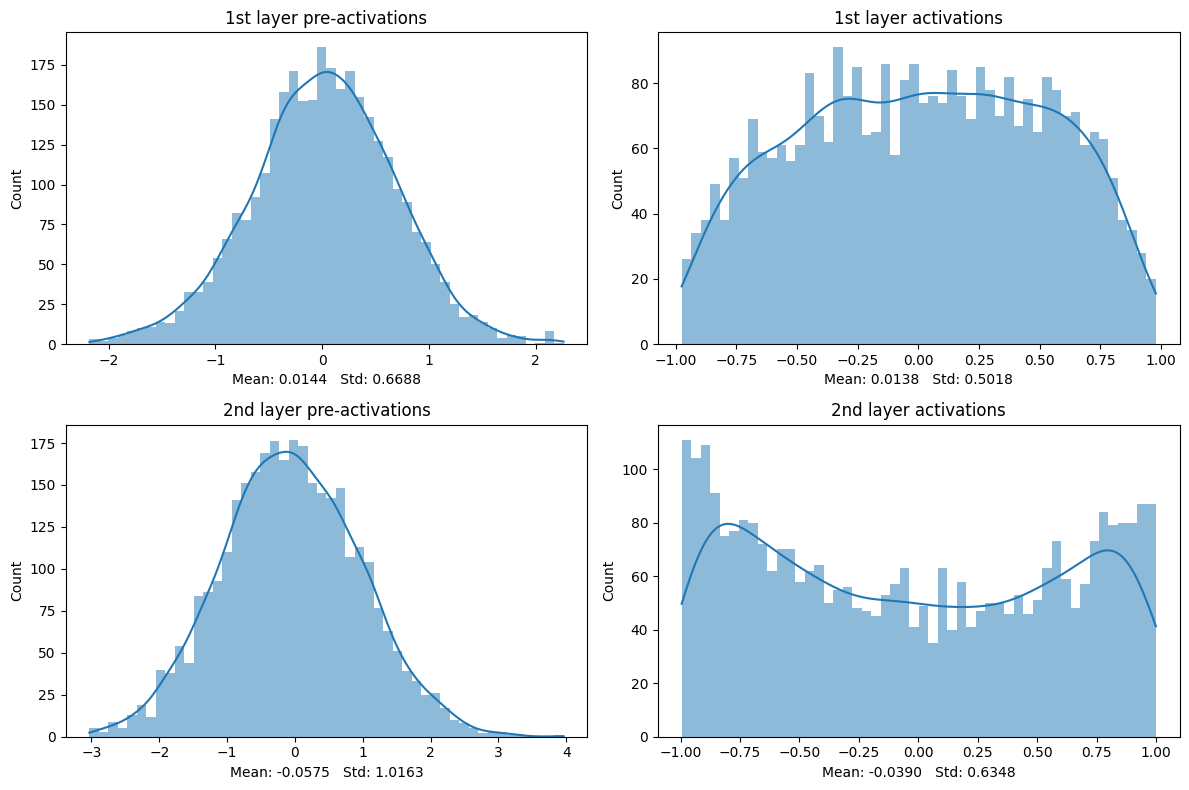

In [26]:
plt.figure(figsize=(12,8))

plt.subplot(221)
sns.histplot(h1_pre.view(-1).tolist(), bins=50, kde=True, edgecolor='none');
plt.title('1st layer pre-activations')
plt.xlabel(f'Mean: {h1_pre.mean():.4f}   Std: {h1_pre.std():.4f}')

plt.subplot(222)
sns.histplot(h1.view(-1).tolist(), bins=50, kde=True, edgecolor='none');
plt.title('1st layer activations')
plt.xlabel(f'Mean: {h1.mean():.4f}   Std: {h1.std():.4f}')

plt.subplot(223)
sns.histplot(h2_pre.view(-1).tolist(), bins=50, kde=True, edgecolor='none');
plt.title('2nd layer pre-activations')
plt.xlabel(f'Mean: {h2_pre.mean():.4f}   Std: {h2_pre.std():.4f}')

plt.subplot(224)
sns.histplot(h2.view(-1).tolist(), bins=50, kde=True, edgecolor='none');
plt.title('2nd layer activations')
plt.xlabel(f'Mean: {h2.mean():.4f}   Std: {h2.std():.4f}')

plt.tight_layout()

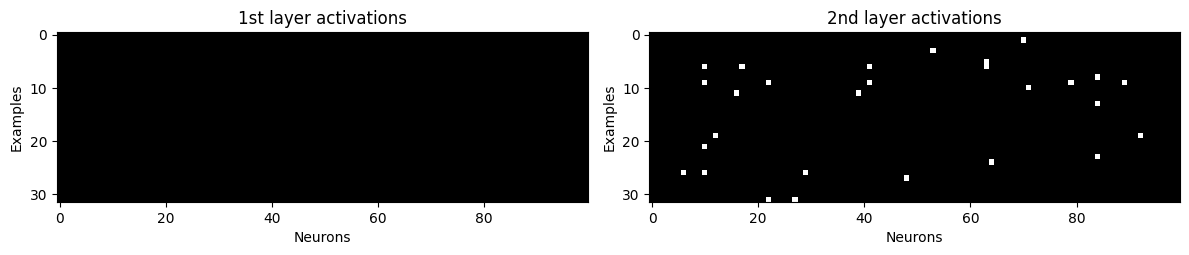

In [27]:
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.imshow(h1.abs() > 0.99, cmap='gray', interpolation='nearest')
plt.title('1st layer activations')
plt.xlabel("Neurons")
plt.ylabel("Examples")

plt.subplot(122)
plt.imshow(h2.abs() > 0.99, cmap='gray', interpolation='nearest')
plt.title('2nd layer activations')
plt.xlabel("Neurons")
plt.ylabel("Examples")

plt.tight_layout()

## Classes for layers

In [40]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=torch.Generator().manual_seed(1)) / fan_in**0.5  # kaiming initialization
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    

class Tanh:

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

In [48]:
def initialize_nn(n_hidden = 100):
    
    layers = [
        Linear(     784, n_hidden), Tanh(),
        Linear(n_hidden, n_hidden), Tanh(),
        Linear(n_hidden,       10),
    ]
    
    with torch.no_grad():
        # make less confident last layer
        layers[-1].weight *= 0.1

        for layer in layers[:-1]:
            if isinstance(layer, Linear):
                layer.weight *= 5/3         # apply kaiming gain
    
    parameters = [p for layer in layers for p in layer.parameters()]
    
    for p in parameters:
        p.requires_grad = True
    
    return layers, parameters

In [ ]:
steps = 100        # train iterations
lr = 0.1           # learning rate
batch_size = 32

g = torch.Generator().manual_seed(1)

# intialize neural network
layers, parameters = initialize_nn()

for step in range(steps):
    
    # batch construction
    ix = torch.randint(0, train_x.shape[0], (batch_size,), generator=g)
    Xb = train_x[ix].view(-1, 784)
    Yb = train_y[ix]
    
    # forward pass
    x = Xb
    for layer in layers:
        x = layer(x)
    
    # calculate loss
    for layer in layers:
        layer.out.retain_grad()       # DEBUG: retain_grad serves for the graphs
    loss = F.cross_entropy(x, Yb)
    if step % 10 == 0 or step == steps - 1:
        print(f"Step: {step:2d}/{steps}     Loss: {loss.item():.4f}")
        
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update parameters
    for p in parameters:
        p.data += -lr * p.grad

print(f"\nTrain Loss: {train_loss():.4f}")

Step:  0/100     Loss: 2.3025
Step: 10/100     Loss: 1.9477
Step: 20/100     Loss: 1.5253
Step: 30/100     Loss: 1.3328
Step: 40/100     Loss: 0.9597
Step: 50/100     Loss: 0.7113
Step: 60/100     Loss: 0.6473
Step: 70/100     Loss: 0.6389
Step: 80/100     Loss: 0.3800
Step: 90/100     Loss: 0.6696
Step: 99/100     Loss: 0.5174

Train Loss: 2.4864


In [67]:
for layer in layers[:-1]:

    if isinstance(layer, Tanh):

        h = layer.out

        print(f"{layer.__class__.__name__}     mean: {h.mean():.4f}     std: {h.std():.4f}     saturation: {(h.abs() > 0.97).float().mean()*100:2f}%")

Tanh     mean: 0.0242     std: 0.4939     saturation: 0.250000%
Tanh     mean: 0.0212     std: 0.6326     saturation: 3.843750%


layer 1 (Tanh)    mean: +0.02    std: 0.49    saturation: 0.25%
layer 3 (Tanh)    mean: +0.02    std: 0.63    saturation: 3.84%


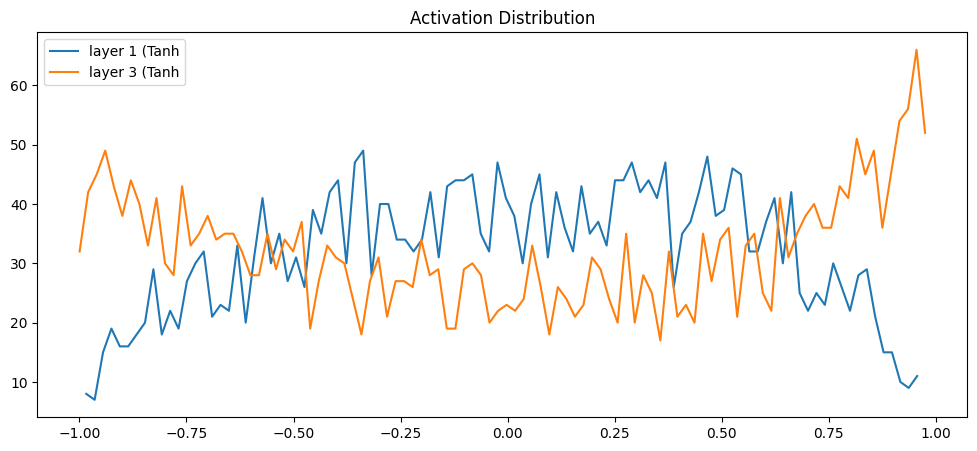

In [ ]:
plt.figure(figsize=(12, 5))
legends = []

for i, layer in enumerate(layers[:-1]): # exclude the output layer

  if isinstance(layer, Tanh):
    
    t = layer.out
    print('layer %d (%s)    mean: %+.2f    std: %.2f    saturation: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')

plt.legend(legends)
plt.title('Activation Distribution');

In [45]:
def initialize_nn(n_hidden = 100):
    
    layers = [
        Linear(     784, n_hidden), Tanh(),
        Linear(n_hidden, n_hidden), Tanh(),
        Linear(n_hidden, n_hidden), Tanh(),
        Linear(n_hidden, n_hidden), Tanh(),
        Linear(n_hidden, n_hidden), Tanh(),
        Linear(n_hidden,       10),
    ]
    
    with torch.no_grad():
        # make less confident last layer
        layers[-1].weight *= 0.1

        for layer in layers[:-1]:
            if isinstance(layer, Linear):
                layer.weight *= 5/3         # apply kaiming gain
    
    parameters = [p for layer in layers for p in layer.parameters()]
    
    for p in parameters:
        p.requires_grad = True
    
    return layers, parameters

In [46]:
steps = 100        # train iterations
lr = 0.1           # learning rate
batch_size = 32

g = torch.Generator().manual_seed(1)

# intialize neural network
layers, parameters = initialize_nn()

for step in range(steps):
    
    # batch construction
    ix = torch.randint(0, train_x.shape[0], (batch_size,), generator=g)
    Xb = train_x[ix].view(-1, 784)
    Yb = train_y[ix]

    # forward pass
    x = Xb
    for layer in layers:
        x = layer(x)
    
    # calculate loss
    loss = F.cross_entropy(x, Yb)
    if step % 10 == 0 or step == steps - 1:
        print(f"Step: {step:2d}/{steps}     Loss: {loss.item():.4f}")
        
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update parameters
    for p in parameters:
        p.data += -lr * p.grad

print(f"\nTrain Loss: {train_loss():.4f}")

Step:  0/100     Loss: 2.3153
Step: 10/100     Loss: 1.7688
Step: 20/100     Loss: 1.2843
Step: 30/100     Loss: 1.1581
Step: 40/100     Loss: 0.7576
Step: 50/100     Loss: 0.4786
Step: 60/100     Loss: 0.6051
Step: 70/100     Loss: 0.4694
Step: 80/100     Loss: 0.3244
Step: 90/100     Loss: 0.6146
Step: 99/100     Loss: 0.5309

Train Loss: 2.4864


layer 1 (Tanh)    mean: -0.02    std: 0.52    saturation: 0.66%
layer 3 (Tanh)    mean: +0.03    std: 0.61    saturation: 2.31%
layer 5 (Tanh)    mean: +0.02    std: 0.66    saturation: 6.25%
layer 7 (Tanh)    mean: +0.00    std: 0.71    saturation: 8.50%
layer 9 (Tanh)    mean: -0.01    std: 0.73    saturation: 13.22%


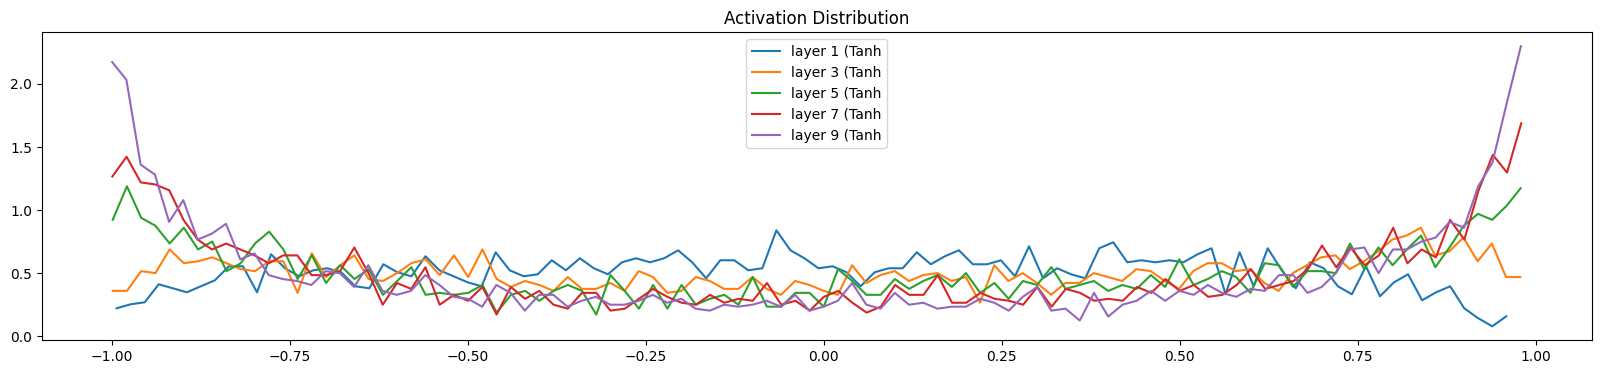

In [47]:
plt.figure(figsize=(20, 4))
legends = []

for i, layer in enumerate(layers[:-1]): # exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%s)    mean: %+.2f    std: %.2f    saturation: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')

plt.legend(legends)
plt.title('Activation Distribution');

## Batch normalization

In [31]:
def initialize_nn(n_hidden = 100):

    g = torch.Generator().manual_seed(1)
    
    W1 = torch.randn((784, n_hidden),      generator=g) * (5/3) / 784**0.5
    gain1 = torch.ones((1, n_hidden))
    bias1 = torch.zeros((1, n_hidden))
    r_mean1= torch.zeros((1, n_hidden))
    r_var1 = torch.ones((1, n_hidden))

    W2 = torch.randn((n_hidden, n_hidden), generator=g) * (5/3) / n_hidden**0.5
    gain2 = torch.ones((1, n_hidden))
    bias2 = torch.zeros((1, n_hidden))
    r_mean2 = torch.zeros((1, n_hidden))
    r_var2 = torch.ones((1, n_hidden))

    W3 = torch.randn((n_hidden, 10),       generator=g) * 0.1
    b3 = torch.randn(10,                   generator=g) * 0

    parameters = [W1, gain1, bias1, W2, gain2, bias2, W3, b3]
    
    for p in parameters:
        p.requires_grad = True
    
    return parameters, r_mean1, r_var1, r_mean2, r_var2

In [32]:
steps = 100        # train iterations
lr = 0.1           # learning rate
batch_size = 32
eps = 1e-5
momentum = 0.1

loss_graph = []
g = torch.Generator().manual_seed(1)

# intialize neural network
parameters, r_mean1, r_var1, r_mean2, r_var2 = initialize_nn()
W1, gain1, bias1, W2, gain2, bias2, W3, b3 = parameters

for step in range(steps):

    # batch construct
    ix = torch.randint(0, x.shape[0], (batch_size,), generator=g)
    
    # forward pass
    h1_pre = x[ix].view(-1, 784) @ W1 + b1                              # linear layer
    mean1 = h1_pre.mean(0, keepdim=True)         
    var1 = h1_pre.var(0, keepdim=True)
    h1_pre = gain1 * (h1_pre - mean1) / torch.sqrt(var1 + eps) + bias1  # batch normalization
    with torch.no_grad():
        r_mean1 = (1 - momentum) * r_mean1 + momentum * mean1
        r_var1 = (1 - momentum) * r_var1 + momentum * var1
    h1 = torch.tanh(h1_pre)                                              # activation function

    h2_pre = h1 @ W2                                                     # linear layer
    mean2 = h2_pre.mean(0, keepdim=True)         
    var2 = h2_pre.var(0, keepdim=True)
    h2_pre = gain2 * (h2_pre - mean2) / torch.sqrt(var2 + eps) + bias2  # batch normalization
    with torch.no_grad():
        r_mean2 = (1 - momentum) * r_mean2 + momentum * mean2
        r_var2 = (1 - momentum) * r_var2 + momentum * var2
    h2 = torch.tanh(h2_pre)                                              # activation function
    
    o = h2 @ W3 + b3

    # calculate loss
    loss = F.cross_entropy(o, labels[ix])
    loss_graph.append(loss.item())
    if step % 10 == 0 or step == steps - 1:
        print(f"Step: {step:2d}/{steps}     Loss: {loss.item():.4f}")

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update parameters
    for p in parameters:
        p.data += -lr * p.grad

print(f"\nTrain Loss: {calculate_loss():.4f}")

RuntimeError: shape '[-1, 784]' is invalid for input of size 320

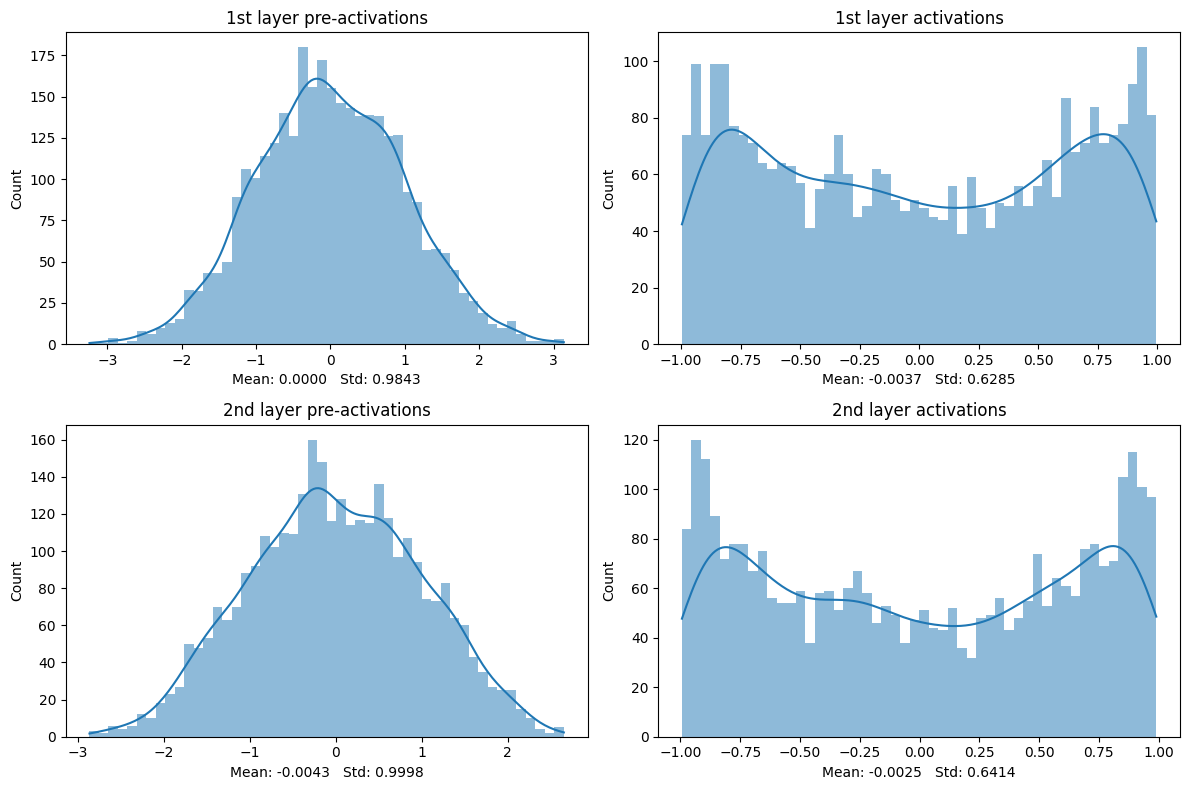

In [240]:
plt.figure(figsize=(12,8))

plt.subplot(221)
sns.histplot(h1_pre.view(-1).tolist(), bins=50, kde=True, edgecolor='none');
plt.title('1st layer pre-activations')
plt.xlabel(f'Mean: {h1_pre.mean():.4f}   Std: {h1_pre.std():.4f}')

plt.subplot(222)
sns.histplot(h1.view(-1).tolist(), bins=50, kde=True, edgecolor='none');
plt.title('1st layer activations')
plt.xlabel(f'Mean: {h1.mean():.4f}   Std: {h1.std():.4f}')

plt.subplot(223)
sns.histplot(h2_pre.view(-1).tolist(), bins=50, kde=True, edgecolor='none');
plt.title('2nd layer pre-activations')
plt.xlabel(f'Mean: {h2_pre.mean():.4f}   Std: {h2_pre.std():.4f}')

plt.subplot(224)
sns.histplot(h2.view(-1).tolist(), bins=50, kde=True, edgecolor='none');
plt.title('2nd layer activations')
plt.xlabel(f'Mean: {h2.mean():.4f}   Std: {h2.std():.4f}')

plt.tight_layout()

In [153]:
# forward pass
h1_prev = train_x.view(-1, 784) @ W1                                      # linear layer
h1_prev = gain1 * (h1_prev - r_mean1) / torch.sqrt(r_var1 + eps) + bias1  # batch normalization
h1 = torch.tanh(h1_prev)                                                  # activation function

h2_prev = h1 @ W2                                                         # linear layer
h2_prev = gain2 * (h2_prev - r_mean2) / torch.sqrt(r_var2 + eps) + bias2  # batch normalization
h2 = torch.tanh(h2_prev)                                                  # activation function

o = h2 @ W3 + b3
probs = o.exp() / o.exp().sum(1, keepdims=True)                           # softmax

# calculate loss
loss = -probs[torch.arange(o.shape[0]), train_y].log().mean()
print(f"Train Loss: {loss.item():.4f}")

Train Loss: 0.4452


In [163]:
class BatchNorm1d:
  
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        self.gain = torch.ones(dim)
        self.bias = torch.zeros(dim)
        self.r_mean = torch.zeros(dim)
        self.r_var = torch.ones(dim)
    
    def __call__(self, x):

        # calculate forward pass
        if self.training:
            mean = x.mean(0, keepdim=True)
            var = x.var(0, keepdim=True)
        else:
            mean = self.r_mean
            var = self.r_var
        self.out = self.gain * (x - mean) / torch.sqrt(var + self.eps) + self.bias

        # update buffers
        if self.training:
            with torch.no_grad():
                self.r_mean = (1 - self.momentum) * self.r_mean + self.momentum * mean
                self.r_var = (1 - self.momentum) * self.r_var + self.momentum * var
        
        return self.out
    
    def parameters(self):
        return [self.gain, self.bias]

In [ ]:
steps = 100        # train iterations
lr = 0.1           # learning rate
batch_size = 32
loss_graph = []

# intialize neural network
layers, parameters = initialize_nn()

for step in range(steps):

    # batch construct
    ix = torch.randint(0, train_x.shape[0], (batch_size,))
    
    # forward pass
    x = train_x[ix]
    for layer in layers:
        x = layer(x)
    probs = x.exp() / x.exp().sum(1, keepdims=True)                      # softmax

    # calculate loss
    loss = -probs[torch.arange(x.shape[0]), train_y[ix]].log().mean()
    loss_graph.append(loss.item())
    if step % 10 == 0 or step == steps - 1:
        print(f"Step: {step:2d}/{steps}     Loss: {loss.item():.4f}")

    # backward pass
    for layer in layers:
        layer.out.retain_grad()       # DEBUG: retain_grad serves for the graphs
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update parameters
    for p in parameters:
        p.data += -lr * p.grad

RuntimeError: mat1 and mat2 shapes cannot be multiplied (896x28 and 784x100)